In [1]:
import pandas as pd

In [2]:
import dowhy

c:\try_causal\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import graphviz

In [4]:
import pygraphviz

In [5]:
import matplotlib.pyplot as plt

In [6]:
# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {'level': 'INFO',
        },
        }
}
logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)


In [7]:
dataset = pd.read_csv('./hotel.csv')
print(dataset.head())
print(dataset.shape)

          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1     

In [8]:
print(dataset.columns)

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')


In [9]:
# Calculate total stay
dataset['total_stay'] = dataset['stays_in_week_nights'] + dataset['stays_in_weekend_nights']
dataset[['stays_in_week_nights', 'stays_in_weekend_nights', 'total_stay']].head()


,stays_in_week_nights,stays_in_weekend_nights,total_stay
0,0,0,0
1,0,0,0
2,1,0,1
3,1,0,1
4,2,0,2


In [10]:
#  Calculate total guests 
dataset['guests'] = dataset['adults']+dataset['children'] +dataset['babies']
dataset[['adults', 'children', 'babies', 'guests']].head()


,adults,children,babies,guests
0,2,0.0,0,2.0
1,2,0.0,0,2.0
2,1,0.0,0,1.0
3,1,0.0,0,1.0
4,2,0.0,0,2.0


In [11]:
# Check whether new room is assigned 
dataset['different_room_assigned']=0
slice_indices = dataset['reserved_room_type']!=dataset['assigned_room_type']
dataset.loc[slice_indices,'different_room_assigned']=1
dataset[['reserved_room_type', 'assigned_room_type', 'different_room_assigned']].head()


,reserved_room_type,assigned_room_type,different_room_assigned
0,C,C,0
1,C,C,0
2,A,C,1
3,A,A,0
4,A,A,0


In [12]:
# Remove attributes used to create new attribute 
dataset = dataset.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies','reserved_room_type','assigned_room_type'],axis=1)
print(dataset.columns)


Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'total_stay', 'guests',
       'different_room_assigned'],
      dtype='object')


In [13]:
# Check missings
print(dataset.isnull().sum()) # country, agent, and company have 488,16340,and 112593 missing values respectively
print(dataset.shape)


hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
booking_changes                        0
deposit_type                           0
agent                              16340
company                           112593
days_in_waiting_list                   0
customer_type                          0
adr                                    0
required_car_parking_spaces            0
total_of_special_requests              0
reservation_status                     0
reservation_stat

In [14]:
# Remove agent and company that have many missings 
dataset = dataset.drop(['agent', 'company'], axis=1)
print(dataset.shape) 


(119390, 26)


In [15]:
# Replace country's missing values with most frequent values 
dataset['country'] = dataset['country'].fillna(dataset['country'].mode()[0])


In [16]:
# Remove useless attributes for analysis 
dataset = dataset.drop(['reservation_status', 'reservation_status_date'], axis=1)
dataset = dataset.drop(['arrival_date_year', 'arrival_date_day_of_month'], axis=1)
dataset = dataset.drop(['distribution_channel'], axis=1)
print(dataset.shape)


(119390, 21)


In [17]:
# Change 1 to True and 0 to False
dataset['different_room_assigned'] = dataset['different_room_assigned'].replace(1, True)
dataset['different_room_assigned'] = dataset['different_room_assigned'].replace(0, False)
dataset['is_canceled'] = dataset['is_canceled'].replace(1, True)
dataset['is_canceled'] = dataset['is_canceled'].replace(0, False)


In [18]:
# Remove examples that have missings 
dataset.dropna(inplace=True)
print(dataset.columns)
print(dataset.shape)
print(dataset.head())


Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests', 'different_room_assigned'],
      dtype='object')
(119386, 21)
          hotel  is_canceled  lead_time arrival_date_month  \
0  Resort Hotel        False        342               July   
1  Resort Hotel        False        737               July   
2  Resort Hotel        False          7               July   
3  Resort Hotel        False         13               July   
4  Resort Hotel        False         14               July   

   arrival_date_week_number meal country market_segment  is_repeated_guest  \
0                        27   BB     PRT         Direct          

In [19]:
# Check number of examples by 'deposit_type' and 'is_canceled'
rs = dataset.groupby(['deposit_type','is_canceled']).count()
print(rs['hotel'])


deposit_type  is_canceled
No Deposit    False          74947
              True           29690
Non Refund    False             93
              True           14494
Refundable    False            126
              True              36
Name: hotel, dtype: int64


In [54]:
# Expected count without no condition
counts_sum=0
for i in range(1,10000):
     counts_i = 0
     # 데이터셋에서 1000개의 행을 랜덤 샘플링한다.
     rdf = dataset.sample(1000)
     # is_candeled TRUE, different_room_assigned TRUE인 행들의 개수를 셈
     counts_i = rdf[rdf["is_canceled"]==rdf["different_room_assigned"] & (rdf['is_canceled']==True)].shape[0]
     # 1000회 반복하면서, 총 몇개의 행들이 같은지 더함  
     counts_sum+= counts_i
print(counts_sum/10000)



635.954


In [55]:
# Expected count when there are no booking changes
counts_sum=0
for i in range(1,10000):
     counts_i = 0
     # 조건을 건 후 1000번을 랜덤 샘플링을 함
     rdf = dataset[dataset["booking_changes"]==0].sample(1000)
     counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"] & (rdf['is_canceled']==True)].shape[0]
     counts_sum+= counts_i
print(counts_sum/10000)


595.9591


In [56]:
# Expected Count when there are booking changes = 66.4%
counts_sum=0
for i in range(1,10000):
    counts_i = 0
    rdf = dataset[dataset["booking_changes"]>0].sample(1000)
    counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
    counts_sum+= counts_i
print(counts_sum/10000)

663.6085


In [ ]:
rs2=dataset[dataset["booking_changes"]==0]
rs2.groupby(['is_canceled','different_room_assigned']).count()

In [36]:
#TRY IF is_cancelled=TRUE, diff room assigned =TRUE
counts_sum=0
for i in range(1,10000):
     counts_i = 0
     # 조건을 건 후 1000번을 랜덤 샘플링을 함
     rdf = dataset[dataset["is_canceled"]==True].sample(1000)
     counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
     counts_sum+= counts_i
print(counts_sum/10000)

#TRY IF is_cancelled=TRUE, diff room assigned =TRUE
counts_sum=0
for i in range(1,10000):
     counts_i = 0
     # 조건을 건 후 1000번을 랜덤 샘플링을 함
     rdf = dataset.sample(1000)
     counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"] & (rdf["is_canceled"]==True)].shape[0]
     counts_sum+= counts_i
print(counts_sum/10000)

#TRY Counting IF is_cancelled=TRUE
counts_sum=0
for i in range(1,10000):
     counts_i = 0
     # 조건을 건 후 1000번을 랜덤 샘플링을 함
     rdf = dataset.sample(1000)
     counts_i = rdf[rdf["is_canceled"]==True].shape[0]
     counts_sum+= counts_i
print(counts_sum/10000)

#TRY Counting IF diff room assigned =TRUE,  is_cancelled=TRUE
counts_sum=0
for i in range(1,10000):
     counts_i = 0
     # 조건을 건 후 1000번을 랜덤 샘플링을 함
     rdf = dataset[dataset["different_room_assigned"]==True].sample(1000)
     counts_i = rdf[rdf["is_canceled"]==True].shape[0]
     counts_sum+= counts_i
print(counts_sum/10000)

#TRY Counting IF diff room assigned =False,  is_cancelled=TRUE
counts_sum=0
for i in range(1,10000):
     counts_i = 0
     # 조건을 건 후 1000번을 랜덤 샘플링을 함
     rdf = dataset[dataset["different_room_assigned"]==False].sample(1000)
     counts_i = rdf[rdf["is_canceled"]==True].shape[0]
     counts_sum+= counts_i
print(counts_sum/10000)

636.1293


In [27]:
import pygraphviz
causal_graph = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders",observed="no"];
is_repeated_guest;
total_stay;
guests;
meal;
hotel;
U->{different_room_assigned,required_car_parking_spaces,guests,total_stay,total_of_special_requests};
market_segment -> lead_time;
lead_time->is_canceled; country -> lead_time;
different_room_assigned -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->{is_canceled,different_room_assigned};
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> {different_room_assigned,is_canceled};
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; booking_changes -> is_canceled;
hotel -> {different_room_assigned,is_canceled};
required_car_parking_spaces -> is_canceled;
total_of_special_requests -> {booking_changes,is_canceled};
country->{hotel, required_car_parking_spaces,total_of_special_requests};
market_segment->{hotel, required_car_parking_spaces,total_of_special_requests};
}"""


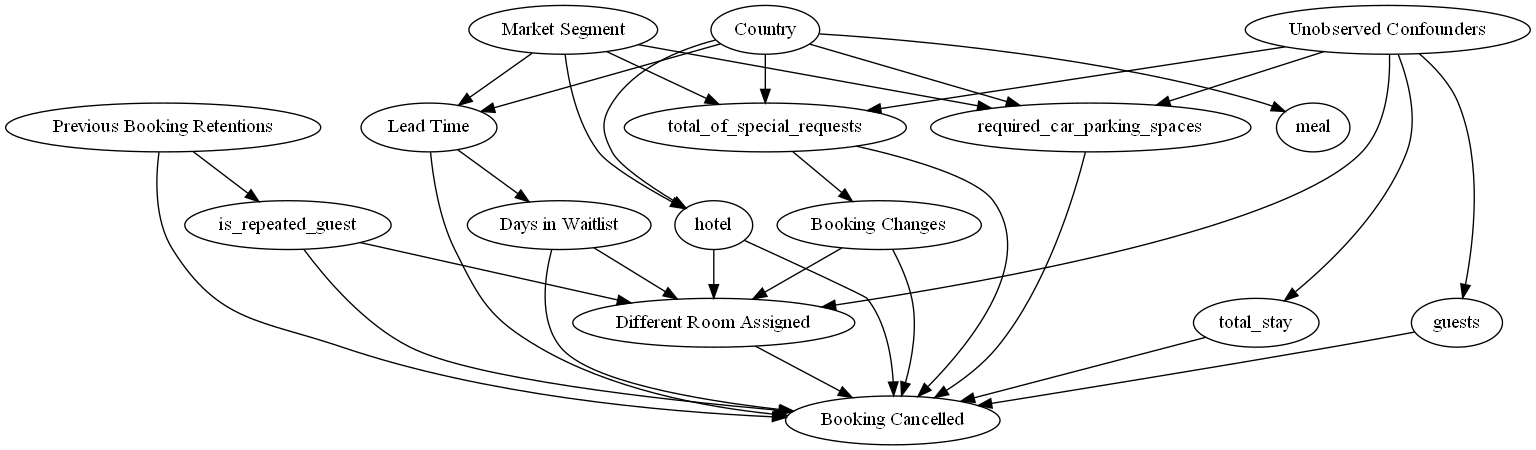

In [28]:
model = dowhy.CausalModel(
    data = dataset,
    graph=causal_graph.replace("\n", " "),
    treatment='different_room_assigned',
    outcome='is_canceled')
model.view_model(size=(16, 12))
from IPython.display import Image, display
display(Image(filename="causal_model.png"))


In [29]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(E[is_canceled|days_in_waiting_list,total_stay,requi
d[different_room_assigned]                                                    

                                                                              
red_car_parking_spaces,hotel,total_of_special_requests,guests,is_repeated_gues
                                                                              

                             
t,booking_changes,lead_time])
                             
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,days_in_waiting_list,total_stay,required_car_parking_spaces,hotel,total_of_special_requests,guests,is_repeated_guest,booking_changes,lead_time,U) = P(is_canceled|different_room_assigned,days_i

In [30]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_weighting",target_units="ate")
print(estimate)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(E[is_canceled|days_in_waiting_list,total_stay,requi
d[different_room_assigned]                                                    

                                                                              
red_car_parking_spaces,hotel,total_of_special_requests,guests,is_repeated_gues
                                                                              

                             
t,booking_changes,lead_time])
                             
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,days_in_waiting_list,total_stay,required_car_parking_spaces,hotel,total_of_special_requests,guests,is_repeated_guest,booking_changes,lead_time,U

In [31]:
refute1_results=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(refute1_results)


Refute: Add a random common cause
Estimated effect:-0.34483085299433924
New effect:-0.3448308529943393
p value:2.0



In [32]:
refute2_results=model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter")
print(refute2_results)


Refute: Use a Placebo Treatment
Estimated effect:-0.34483085299433924
New effect:0.09364898133708036
p value:0.0



In [33]:
refute3_results=model.refute_estimate(identified_estimand, estimate, method_name="data_subset_refuter")
print(refute3_results)


Refute: Use a subset of data
Estimated effect:-0.34483085299433924
New effect:-0.34474558699317265
p value:0.94

